# Real World Dataset - Exploratory Data Analysis

This is a notebook to examine and clean the University of Mannheim Real World Dataset, which can be downloaded here (https://www.uni-mannheim.de/dws/research/projects/activity-recognition/dataset/dataset-realworld/), and format it in a way that can be used by the Flare AI model. The dataset is seperated into separate files by test subject (there are fifteen of various age, sex, height and weight), activity type (walking, running, sitting, standing, lying, climbing up, climbing down, jumping), and instrument (accelerometer, GPS, gyroscope, light sensor, magnetic field sensor, sound level). Each subject was fitted with sensors on the head, chest, thigh, waist, wrist, lower leg and upper arm. 

For the purposes of this analysis, we have taken a moderately-sized sample of the whole dataset, using four subjects out of the fifteen -  Subjects 1, 4, 5, and 6. These were chosen to give a good sample of age, height, weight and sex:


| Subject | Sex | Age | Height /m | Weight /kg | Occupation |
| --- | --- | --- | --- | --- | --- |
| Subject 1 | F | 52 | 1.63 | 48 | Industrial Management Assistant |
| Subject 4 | M | 26 | 1.83 | 83 | Business Informatics |
| Subject 5 | M | 62 | 1.70 | 70 | Telecommunication Engineer |
| Subject 6 | F | 24 | 1.74 | 67 | Geriatric Nurse Assistant |

The sensor data taken from these subjects was further restricted by the number of activities in which we consider important for our model - namely, climbing up, climbing down and jumping have been discarded. In addition, since we expect the vast majority of app users will have their phones in their pocket, and not, for example on their head, we have used the datasets for the 'thigh' position only.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import skew, kurtosis

df = pd.read_csv('C:\\Users\\EoinB\\Dev\\Data\\Real-world-data\\Subject_6\\acc_running_thigh.csv').drop(columns='id')
df.head()

,attr_time,attr_x,attr_y,attr_z
0,1436465583077,-1.012747,9.524733,-0.960673
1,1436465583078,-0.994791,9.469667,-0.975039
2,1436465583079,-0.976236,9.463082,-0.999579
3,1436465583080,-0.951695,9.466674,-1.006163
4,1436465583081,-0.915782,9.482835,-1.033098


On inspecting the 'running' datasets, it became clear that the subject stopped running and rested for certain periods within the ~10m test period. This was confirmed by watching the videos of the test subjects undertaking the trial:

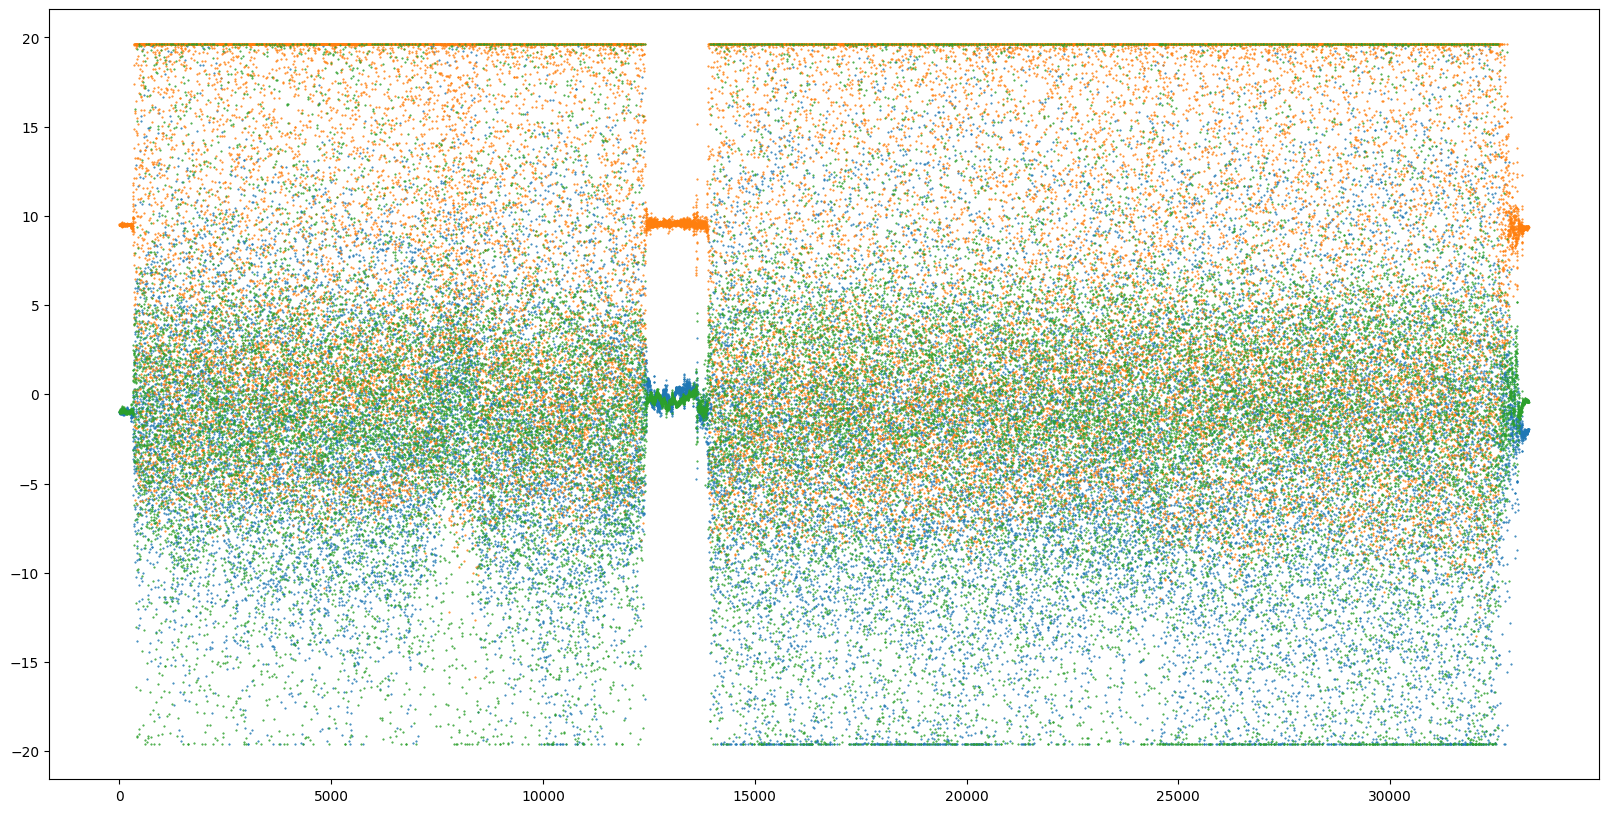

In [103]:
plt.figure(figsize=(20,10))
plt.plot(df[['attr_x','attr_y','attr_z']],'.',markersize=1)

In [3]:
# Calculates the max, min, range and moments of samples in time series.

# Tries to calculate the skew of a set of values, returns 0 if skew(x) = NaN. We need this because sometimes sigma = 0, which gives a division error.
def skew_no_nans(x: float) -> float:
    if np.std(x) == 0:
        return 0
    else:
        return skew(x)

# Same again, but with kurt.
def kurt_no_nans(x: float) -> float:
    if np.std(x) == 0:
        return 0
    else:
        return kurtosis(x)

def column_names(dataSeries: pd.DataFrame) -> list:
    metrics = ['min','max','diff','std','var','skew','kurt']
    return [metric + dataSeries.name for metric in metrics]

def maxMinDiff(dataSeries: pd.DataFrame, output_df = True, sampleSize=100):
    sampleMax = []
    sampleMin = []
    sampleRange = []
    sampleStd = []
    sampleVar = []
    sampleSkew = []
    sampleKurt = []
    for i in range(0,len(dataSeries),sampleSize): 
        sampleMax.append(dataSeries[i:(i+sampleSize)].max())
        sampleMin.append(dataSeries[i:(i+sampleSize)].min())
        sampleRange.append(dataSeries[i:(i+sampleSize)].max()-dataSeries[i:(i+sampleSize)].min())
        sampleStd.append(np.std(dataSeries[i:(i+sampleSize)]))
        sampleVar.append(np.var(dataSeries[i:(i+sampleSize)]))
        sampleSkew.append((skew_no_nans(dataSeries[i:(i+sampleSize)])))
        sampleKurt.append((kurt_no_nans(dataSeries[i:(i+sampleSize)])))

    output = np.array([sampleMax,sampleMin, sampleRange,sampleStd,sampleVar, sampleSkew, sampleKurt,]).T

    if output_df == False:
        return output
    else:
        return pd.DataFrame(output, columns=column_names(dataSeries)).fillna(0)
    
# This processes all columns at once and sticks them together.
def Process(df: pd.DataFrame, columns = ['attr_x','attr_y','attr_z']) -> pd.DataFrame:
    # The [:-1] gets rid of the time column.
    data = [maxMinDiff(df[column],output_df=False) for column in columns]
    column_labels = np.hstack([np.array(column_names(df[column])) for column in columns])
    return pd.DataFrame(np.hstack(data),columns=column_labels)

The script in the following cell, in addition to formatting the data into various ensemble statistics of two second time windows, filters out the all rows in which the standard deviation of the y acceleration is less than 5. This is expected to catch most of the times in which the subject is resting rather than actually running. 

In [42]:
'''Data wrangling'''
activity_types = ['lying','running','walking','sitting','standing']
instrument = ['acc','Gyroscope']

'''Helper Functions'''
def extractLabel(filename: str) -> str:
    for activity in activity_types:
        if activity in filename:
            return activity
        
def extractSubject(filename: str) -> str:
    for subject in os.listdir('C:\\Users\\EoinB\\Dev\\Data\\Real-world-data'):
        if subject in filename:
            return subject

# Extracts data from files and output into a list of dataframes.
filenames = []
for subject in ['Subject_1', 'Subject_4', 'Subject_5', 'Subject_6']:
    for activity in os.listdir(f'C:\\Users\\EoinB\\Dev\\Data\\Real-world-data\\{subject}'):
        filenames.append(f'C:\\Users\\EoinB\\Dev\\Data\\Real-world-data\\{subject}\\{activity}')

acc_list = [filename for filename in filenames if 'acc' in filename]
gyr_list = [filename for filename in filenames if 'Gyroscope' in filename]

dfs_acc = [] 
for filename in acc_list:
    dataframe = pd.read_csv(filename).drop(columns=['id','attr_time'])
    dataframe.columns = ['accelX','accelY','accelZ']
    dataframe_ = Process(dataframe,dataframe.columns)
    # dataframe_['subject'] = [extractSubject(filename)]*len(dataframe_)
    # dataframe_['label'] = [extractLabel(filename)]*len(dataframe_)
    dfs_acc.append(dataframe_)

dfs_gyr = [] 
for filename in gyr_list:
    dataframe = pd.read_csv(filename).drop(columns=['id','attr_time'])
    dataframe.columns = ['gyroX','gyroY','gyroZ']
    dataframe_ = Process(dataframe,dataframe.columns)
    dataframe_['subject'] = [extractSubject(filename)]*len(dataframe_)
    dataframe_['label'] = [extractLabel(filename)]*len(dataframe_)
    dfs_gyr.append(dataframe_)

# Merges the lists of acceleration and gyroscope datasets and puts the test subject and label on the end.
dfs = [pd.concat([dfs_acc[i],dfs_gyr[i]],axis=1) for i in range(len(dfs_acc))]

# Concatenate the list of datasets.
df = pd.concat(dfs,ignore_index=True)

# Filter out the times the test subject was actually standing still in the entries labelled 'running'.
df_run = df[df['label'] == 'running']
indices_to_drop = []
for i in df_run.index:
    if df_run['stdaccelY'][i] < 5:
        indices_to_drop.append(i)

df_ = df.drop(indices_to_drop).reset_index(drop=True)

The file is exported to csv. Its size is approximately 1.5GB.

In [205]:
df_.to_csv('C:\\Users\\EoinB\\dev\\data\\Real-World-Data\\Dataset.csv')

The files can also be wrangled together into the correct format by running the script "C:\Users\EoinB\Dev\Data\Real-world-data\Real-World-Wrangler.py" from the command line, changing the filepath where necessary.